In [135]:
import tensorflow as tf
import numpy as np 
import pandas as pd 
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os
from sklearn.model_selection import train_test_split
np.random.seed(42)
tf.random.set_seed(42)

In [136]:
df_sun = pd.read_csv('../data mining/Sunspots.csv')

In [137]:
def plot_series(time, series, format="-", start=0, end=None):
    if not isinstance(series, pd.Series):
        series = pd.Series(series, index=time)
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [138]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)


In [139]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [140]:
#split dataset
split_time = 2500
trainset = df_sun.iloc[:split_time]
validset = df_sun.iloc[split_time:]
allseries=df_sun['Monthly Mean Total Sunspot Number']
#训练集
trainseries = trainset ['Monthly Mean Total Sunspot Number']
traintime = trainset['Unnamed: 0']
#测试集
time_valid = validset['Unnamed: 0']
series_valid = validset['Monthly Mean Total Sunspot Number']

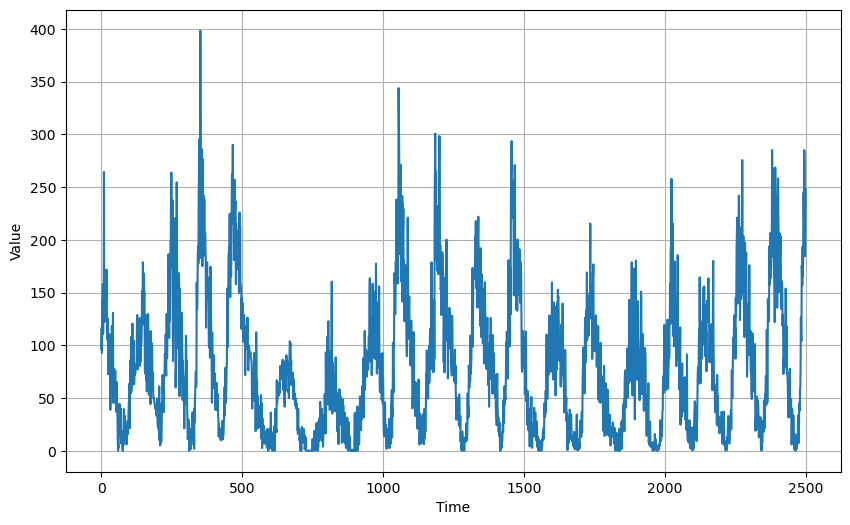

In [141]:


plt.figure(figsize=(10, 6))
plot_series(traintime, trainseries)

In [142]:
df_smooth=df_sun.copy()

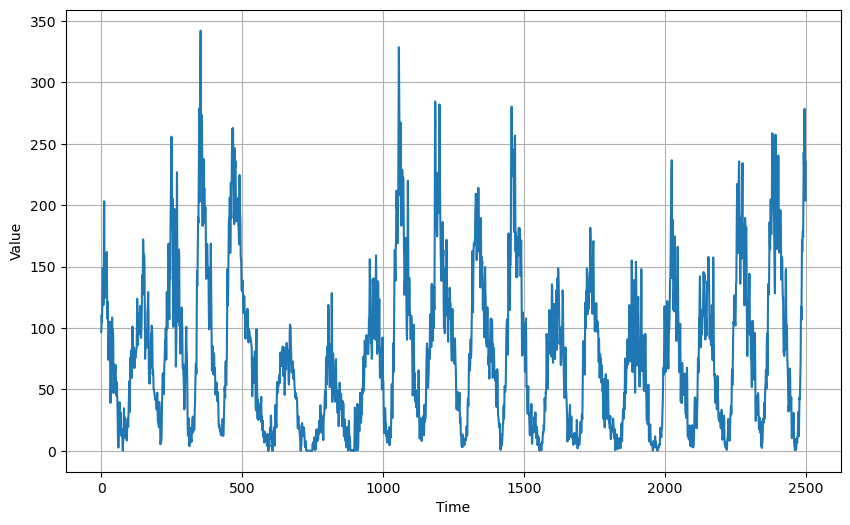

In [143]:
# 定义简单移动平均函数
def simple_moving_average(data, window_size):
    return data.rolling(window=window_size, min_periods=1).mean()
    # return data.ewm(span=window_size, adjust=False).mean()
window_size = 2
#对所有数据进行平滑后
series_smooth = simple_moving_average(df_smooth['Monthly Mean Total Sunspot Number'] , window_size)
df_smooth['Monthly Mean Total Sunspot Number']=series_smooth

#split dataset
trainset1 = df_smooth.iloc[:split_time]
validset1= df_smooth.iloc[split_time:]
#训练集
trainseries1 = trainset1 ['Monthly Mean Total Sunspot Number']
traintime1 = trainset1['Unnamed: 0']
#测试集
time_valid1 = validset1['Unnamed: 0']
series_valid1 = validset1['Monthly Mean Total Sunspot Number']



# 绘制降噪后的数据
plt.figure(figsize=(10, 6))
plot_series(traintime1 , trainseries1)


In [144]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

shuffle_buffer_size = 1000
window_size = 64
batch_size = 64

# Use windowed_dataset function to make dataset suitable
train_set = windowed_dataset(trainseries, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(trainseries.shape)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>
(2500,)


In [145]:
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=7e-6, momentum=0.9)
loss = tf.keras.losses.Huber()

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                          strides=1, padding='causal',
                          activation='relu',
                          input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])


model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])

history = model.fit(train_set, epochs=20)

Epoch 1/20
39/39 [==============================] - 2s 28ms/step - loss: 45.6016 - mae: 46.0990
Epoch 2/20
39/39 [==============================] - 1s 28ms/step - loss: 29.8204 - mae: 30.3158
Epoch 3/20
39/39 [==============================] - 1s 28ms/step - loss: 24.3293 - mae: 24.8237
Epoch 4/20
39/39 [==============================] - 1s 29ms/step - loss: 21.5610 - mae: 22.0545
Epoch 5/20
39/39 [==============================] - 1s 29ms/step - loss: 20.2315 - mae: 20.7244
Epoch 6/20
39/39 [==============================] - 1s 29ms/step - loss: 19.4374 - mae: 19.9303
Epoch 7/20
39/39 [==============================] - 1s 29ms/step - loss: 19.0559 - mae: 19.5485
Epoch 8/20
39/39 [==============================] - 1s 29ms/step - loss: 18.6756 - mae: 19.1680
Epoch 9/20
39/39 [==============================] - 1s 29ms/step - loss: 18.4300 - mae: 18.9221
Epoch 10/20
39/39 [==============================] - 1s 29ms/step - loss: 18.3014 - mae: 18.7935
Epoch 11/20
39/39 [====================

### 平滑前

101/101 [==============================] - 1s 5ms/step

MAE: 19.872652


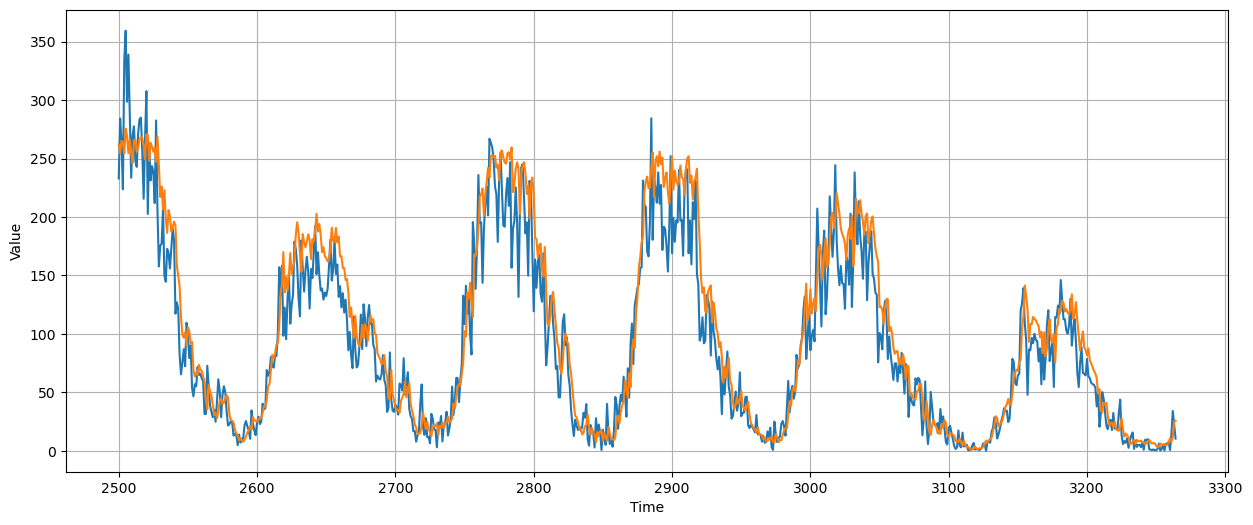

In [146]:

# 使用训练好的模型对数据进行预测
rnn_forecast = model_forecast(model, np.array(allseries)[..., np.newaxis], window_size)
# 对预测结果进行处理
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

# 计算 MAE
mae = tf.keras.metrics.mean_absolute_error(series_valid, rnn_forecast).numpy()
print('\nMAE:', mae)

# 绘制真实值和预测值的对比图
plt.figure(figsize=(15, 6))
plot_series(time_valid , series_valid)
plot_series(time_valid , rnn_forecast)
plt.show()

### 平滑后

In [147]:
train_set1 = windowed_dataset(trainseries1, window_size, batch_size, shuffle_buffer_size)

In [148]:
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=7e-6, momentum=0.9)
loss = tf.keras.losses.Huber()

model1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                          strides=1, padding='causal',
                          activation='relu',
                          input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])


model1.compile(loss=loss, optimizer=optimizer, metrics=['mae'])

history = model1.fit(train_set1, epochs=20)

Epoch 1/20
39/39 [==============================] - 2s 27ms/step - loss: 28.6414 - mae: 29.1361
Epoch 2/20
39/39 [==============================] - 1s 27ms/step - loss: 17.6829 - mae: 18.1745
Epoch 3/20
39/39 [==============================] - 1s 28ms/step - loss: 15.2965 - mae: 15.7875
Epoch 4/20
39/39 [==============================] - 1s 28ms/step - loss: 14.3824 - mae: 14.8728
Epoch 5/20
39/39 [==============================] - 1s 28ms/step - loss: 13.5745 - mae: 14.0643
Epoch 6/20
39/39 [==============================] - 1s 28ms/step - loss: 13.8825 - mae: 14.3726
Epoch 7/20
39/39 [==============================] - 1s 28ms/step - loss: 12.0683 - mae: 12.5572
Epoch 8/20
39/39 [==============================] - 1s 28ms/step - loss: 12.6437 - mae: 13.1327
Epoch 9/20
39/39 [==============================] - 1s 29ms/step - loss: 11.7822 - mae: 12.2702
Epoch 10/20
39/39 [==============================] - 1s 28ms/step - loss: 11.2497 - mae: 11.7375
Epoch 11/20
39/39 [====================

101/101 [==============================] - 1s 5ms/step

MAE: 10.23662


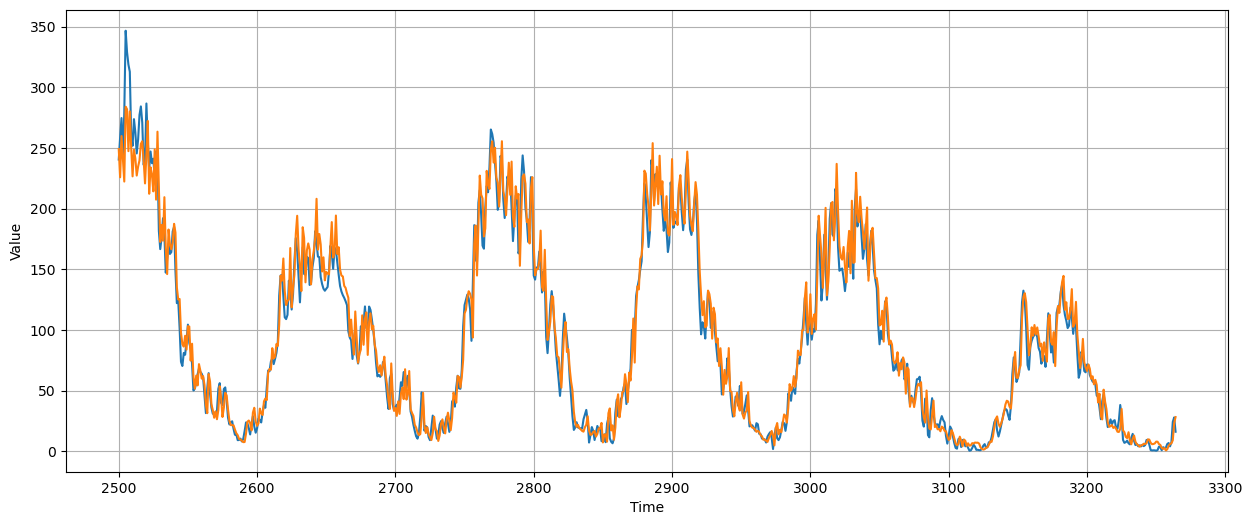

In [149]:

# 使用训练好的模型对数据进行预测
rnn_forecast = model_forecast(model1, np.array(series_smooth)[..., np.newaxis], window_size)
# 对预测结果进行处理
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

# 计算 MAE
mae = tf.keras.metrics.mean_absolute_error(series_valid1, rnn_forecast).numpy()
print('\nMAE:', mae)

# 绘制真实值和预测值的对比图
plt.figure(figsize=(15, 6))
plot_series(time_valid1 , series_valid1)
plot_series(time_valid1 , rnn_forecast)
plt.show()

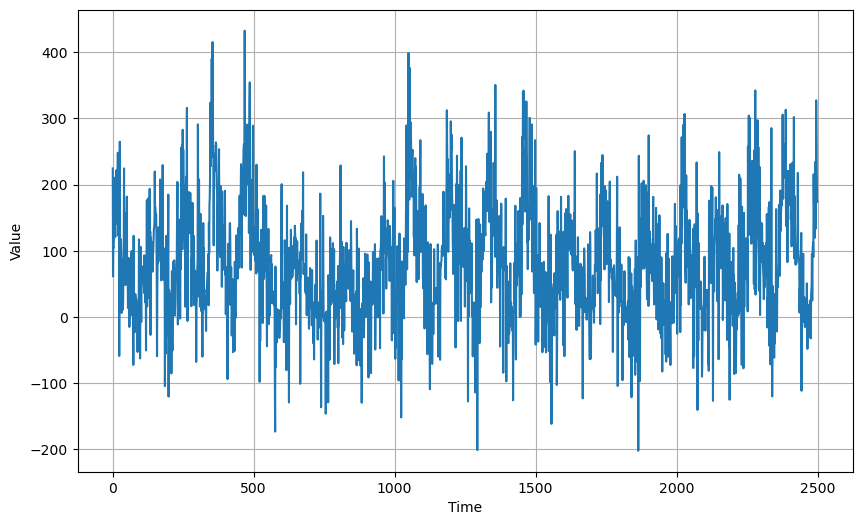

In [150]:
def add_noise(df, column, mean=0):
    mc_data = df.copy(deep=True)
    stddev = np.std(mc_data[column])
    sampled_rows = mc_data.sample(frac=0.5)
    noise = np.random.normal(mean, stddev, size=len(sampled_rows))
    df.loc[sampled_rows.index, column] += noise

# 添加噪声
add_noise(trainset1,'Monthly Mean Total Sunspot Number')



time_before= trainset1['Unnamed: 0']
x_train_noise = trainset1['Monthly Mean Total Sunspot Number']
plt.figure(figsize=(10, 6))
plot_series(time_before , x_train_before  )


In [151]:
tf.random.set_seed(42)
np.random.seed(42)
train_set = windowed_dataset(x_train_noise, window_size, batch_size, shuffle_buffer_size)

optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=7e-6, momentum=0.9)
# optimizer = tf.keras.optimizers.SGD(lr=7e-6, momentum=0.9)
loss = tf.keras.losses.Huber()

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                          strides=1, padding='causal',
                          activation='relu',
                          input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])


model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])

history = model.fit(train_set, epochs=20)

Epoch 1/20
39/39 [==============================] - 2s 28ms/step - loss: 47.6572 - mae: 48.1545
Epoch 2/20
39/39 [==============================] - 1s 27ms/step - loss: 40.9782 - mae: 41.4749
Epoch 3/20
39/39 [==============================] - 1s 28ms/step - loss: 39.0868 - mae: 39.5829
Epoch 4/20
39/39 [==============================] - 1s 28ms/step - loss: 38.0802 - mae: 38.5759
Epoch 5/20
39/39 [==============================] - 1s 28ms/step - loss: 37.4754 - mae: 37.9709
Epoch 6/20
39/39 [==============================] - 1s 28ms/step - loss: 36.9735 - mae: 37.4686
Epoch 7/20
39/39 [==============================] - 1s 29ms/step - loss: 36.6885 - mae: 37.1836
Epoch 8/20
39/39 [==============================] - 1s 28ms/step - loss: 36.6562 - mae: 37.1512
Epoch 9/20
39/39 [==============================] - 1s 28ms/step - loss: 36.1590 - mae: 36.6538
Epoch 10/20
39/39 [==============================] - 1s 28ms/step - loss: 35.8041 - mae: 36.2987
Epoch 11/20
39/39 [====================

In [152]:
series_noise=pd.concat([x_train_noise,series_valid1])
print(series_noise)

0        96.700000
1       100.500000
2       204.501041
3       104.750000
4       117.250000
           ...    
3260      4.050000
3261      7.500000
3262     24.200000
3263     27.900000
3264     16.100000
Name: Monthly Mean Total Sunspot Number, Length: 3265, dtype: float64


101/101 [==============================] - 1s 5ms/step

MAE: 11.533613


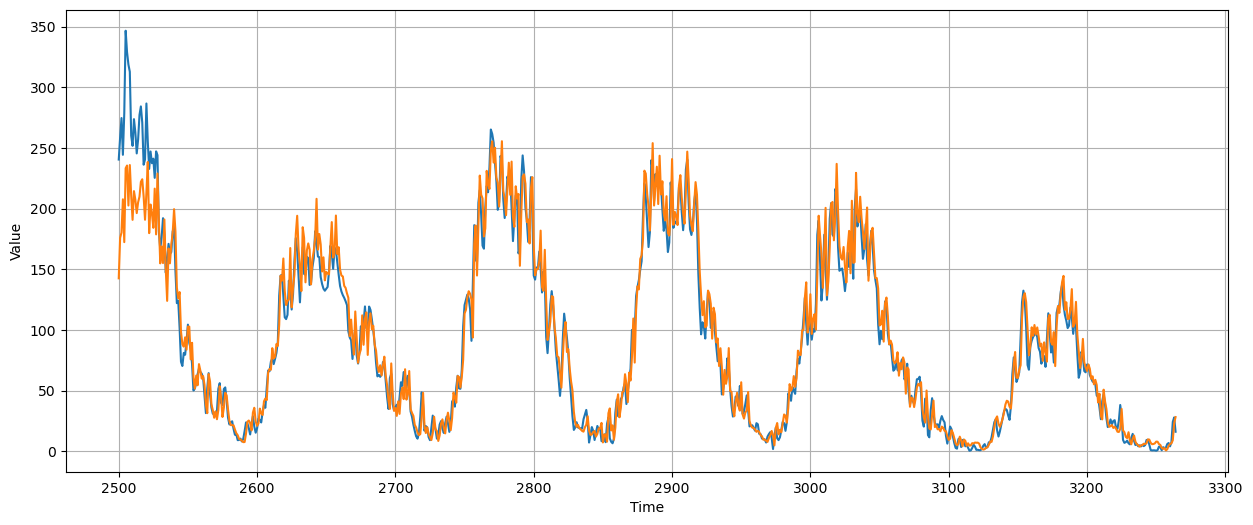

In [153]:

# 使用训练好的模型对数据进行预测
rnn_forecast = model_forecast(model1, np.array(series_noise)[..., np.newaxis], window_size)
# 对预测结果进行处理
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

# 计算 MAE
mae = tf.keras.metrics.mean_absolute_error(series_valid1, rnn_forecast).numpy()
print('\nMAE:', mae)

# 绘制真实值和预测值的对比图
plt.figure(figsize=(15, 6))
plot_series(time_valid1 , series_valid1)
plot_series(time_valid1 , rnn_forecast)
plt.show()

In [154]:
# series_noise=pd.concat([x_train_noise,series_valid1])

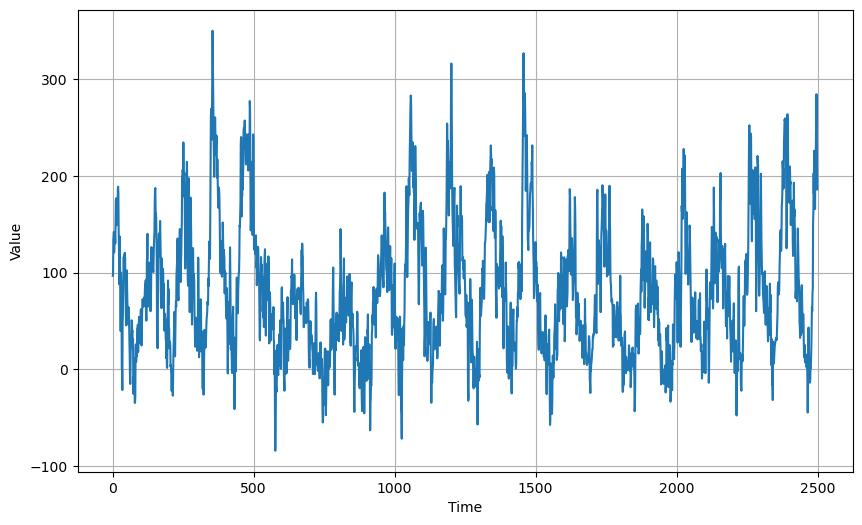

In [155]:

def simple_moving_average(data, window_size):
    return data.rolling(window=window_size, min_periods=1).mean()
    # return data.ewm(span=window_size, adjust=False).mean()

window_size = 3

series_smooth = simple_moving_average(x_train_noise , window_size)
series_smoothed=pd.concat([series_smooth,series_valid1])




plt.figure(figsize=(10, 6))
plot_series(traintime1 , series_smooth )


In [156]:
tf.random.set_seed(42)
np.random.seed(42)
train_set = windowed_dataset(series_smoothed, window_size, batch_size, shuffle_buffer_size)

optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=7e-6, momentum=0.9)
# optimizer = tf.keras.optimizers.SGD(lr=7e-6, momentum=0.9)
loss = tf.keras.losses.Huber()

model2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                          strides=1, padding='causal',
                          activation='relu',
                          input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])


model2.compile(loss=loss, optimizer=optimizer, metrics=['mae'])

history = model2.fit(train_set, epochs=20)

Epoch 1/20
51/51 [==============================] - 1s 2ms/step - loss: 53.3834 - mae: 53.8810
Epoch 2/20
51/51 [==============================] - 0s 2ms/step - loss: 23.6934 - mae: 24.1878
Epoch 3/20
51/51 [==============================] - 0s 2ms/step - loss: 18.6339 - mae: 19.1275
Epoch 4/20
51/51 [==============================] - 0s 2ms/step - loss: 17.4351 - mae: 17.9282
Epoch 5/20
51/51 [==============================] - 0s 2ms/step - loss: 16.7231 - mae: 17.2161
Epoch 6/20
51/51 [==============================] - 0s 2ms/step - loss: 16.4448 - mae: 16.9356
Epoch 7/20
51/51 [==============================] - 0s 2ms/step - loss: 15.9647 - mae: 16.4563
Epoch 8/20
51/51 [==============================] - 0s 2ms/step - loss: 15.8551 - mae: 16.3466
Epoch 9/20
51/51 [==============================] - 0s 2ms/step - loss: 15.7064 - mae: 16.1983
Epoch 10/20
51/51 [==============================] - 0s 2ms/step - loss: 15.9550 - mae: 16.4470
Epoch 11/20
51/51 [==============================

102/102 [==============================] - 0s 639us/step

MAE: 10.479638


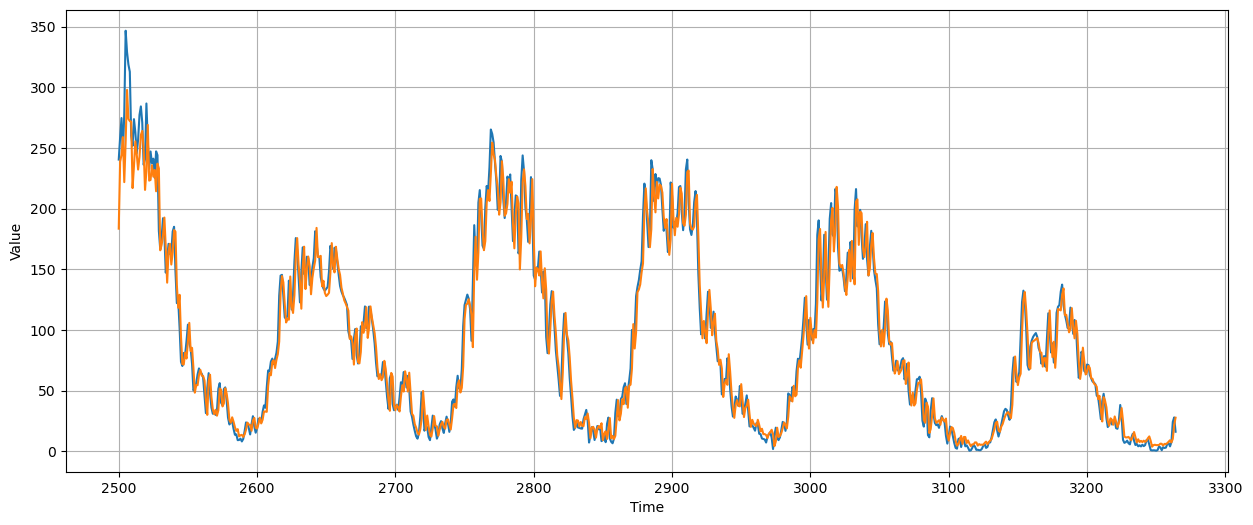

In [157]:

rnn_forecast = model_forecast(model2, np.array(series_smoothed)[..., np.newaxis], window_size)


rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]


mae = tf.keras.metrics.mean_absolute_error(series_valid1, rnn_forecast).numpy()
print('\nMAE:', mae)


plt.figure(figsize=(15, 6))
plot_series(time_valid, series_valid1)
plot_series(time_valid, rnn_forecast)
plt.show()